In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("../../../..")
from analysis_functions import *

In [2]:
# Загрузка данных
X_stress_components_new = opener(
    "X_stress_components_new_components",
    path_import="../../../../new_components_resources",
)
X_strain_components_new = opener(
    "X_strain_components_new_components",
    path_import="../../../../new_components_resources",
)
y_stress_components_new = opener(
    "y_stress_components_new_components",
    path_import="../../../../new_components_resources",
)
y_strain_components_new = opener(
    "y_strain_components_new_components",
    path_import="../../../../new_components_resources",
)
# X_stress_components_other = opener('X_stress_components_other')
# X_strain_components_other = opener('X_strain_components_other')
# y_stress_components_other = opener('y_stress_components_other')
# y_strain_components_other = opener('y_strain_components_other')


../../../../new_components_resources/X_stress_components_new_components.pkl
../../../../new_components_resources/X_strain_components_new_components.pkl
../../../../new_components_resources/y_stress_components_new_components.pkl
../../../../new_components_resources/y_strain_components_new_components.pkl


In [3]:
component_num = 1

X, y = (X_stress_components_new[component_num], 
        y_stress_components_new[component_num])

## Простое обучение

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error


# Разделение данных на обучающую, валидационную и тестовую выборки
cur_X_train, cur_X_test, cur_y_train, cur_y_test = split_transform_one_comp_train_test(
    X, y
)

# Обучение модели
model = DecisionTreeRegressor(
    random_state=RANDOM_STATE, max_depth=10, min_samples_split=2
)
model.fit(cur_X_train, cur_y_train)

# Предсказание
cur_y_pred = model.predict(cur_X_test)

# Оценка качества
rmse = root_mean_squared_error(cur_y_test, cur_y_pred)
print(f"RMSE test: {rmse:.2f}")

# На трейне
cur_y_pred_train = model.predict(cur_X_train)
rmse_train = root_mean_squared_error(cur_y_train, cur_y_pred_train)
print(f"RMSE train: {rmse_train:.2f}")

RMSE test: 11.49
RMSE train: 11.01


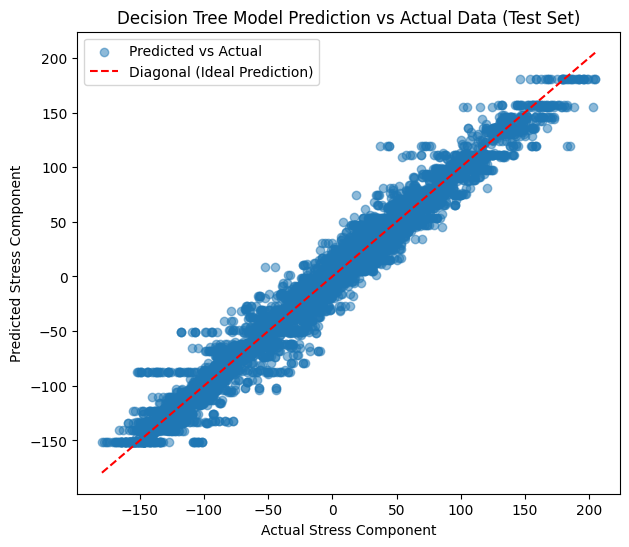

In [5]:
# Plotting the results on the test set
plt.figure(figsize=(7, 6))
plt.scatter(cur_y_test, cur_y_pred, alpha=0.5, label="Predicted vs Actual")
plt.plot(
    [min(cur_y_test), max(cur_y_test)],
    [min(cur_y_test), max(cur_y_test)],
    color="red",
    linestyle="--",
    label="Diagonal (Ideal Prediction)",
)
plt.xlabel("Actual Stress Component")
plt.ylabel("Predicted Stress Component")
plt.title("Decision Tree Model Prediction vs Actual Data (Test Set)")
plt.legend()
plt.show()

## Добавляю кросс-валидацию

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score


n_splits = 5
# Preparing datasets
cur_X_test, cur_y_test, val_list_X, val_list_y, train_list_X, train_list_y = (
    split_transform_one_comp_cv(X, y, n_splits=n_splits)
)


def do_optuna_for_tree(X, y, n_trials=200, **kwargs):
    n_splits = kwargs.get("n_splits", 3)

    def optuna_decision_tree_val(trial):
        max_depth = trial.suggest_int("max_depth", 1, 32)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 32)

        params = {
            "max_depth": max_depth,
            "min_samples_split": min_samples_split,
            "random_state": RANDOM_STATE,
        }

        # Fitting and scoring `n_split` times
        errors = np.zeros((n_splits, 9))

        for split_idx in range(n_splits):
            regr = DecisionTreeRegressor(**params)

            cur_X_train = train_list_X[split_idx]
            cur_y_train = train_list_y[split_idx]

            cur_X_val = val_list_X[split_idx]
            cur_y_val = val_list_y[split_idx]

            cur_X_train, cur_y_train = clean_input_array(cur_X_train, cur_y_train)
            cur_X_val, cur_y_val = clean_input_array(cur_X_val, cur_y_val)

            regr.fit(cur_X_train, cur_y_train)

            #######  Validation  ########
            #  Prediction
            cur_prediction = regr.predict(cur_X_val)
            # Scoring
            errors[split_idx] = scorer(cur_y_val, cur_prediction, regr, cur_X_train)

        # Collect validation result
        val_metrics = choose_worst(errors)
        return_value = (
            val_metrics[-1] if pd.notnull(val_metrics[-1]) else +1e6
        )  # для rmse
        return return_value

    # Create a study object to optimize the objective
    study = optuna.create_study(direction="minimize")  # rmse
    study.optimize(optuna_decision_tree_val, n_trials=n_trials, n_jobs=-1)

    # Print the best hyperparameters found by Optuna
    best_params = study.best_params
    best_value = study.best_value
    print("Best Hyperparameters:", best_params)

    return best_params, cur_X_test, cur_y_test, best_value


# Use the function
best_params, cur_X_test, cur_y_test, best_value = do_optuna_for_tree(X, y, n_splits=n_splits)


[I 2025-05-16 14:52:27,243] A new study created in memory with name: no-name-289eabf5-3e9e-4c07-b8f4-2492e38cea2b
[I 2025-05-16 14:52:27,326] Trial 4 finished with value: 32.814045742247885 and parameters: {'max_depth': 3, 'min_samples_split': 23}. Best is trial 4 with value: 32.814045742247885.
[I 2025-05-16 14:52:27,403] Trial 3 finished with value: 15.076778180011205 and parameters: {'max_depth': 8, 'min_samples_split': 26}. Best is trial 3 with value: 15.076778180011205.
[I 2025-05-16 14:52:27,414] Trial 6 finished with value: 11.138791367657893 and parameters: {'max_depth': 31, 'min_samples_split': 29}. Best is trial 6 with value: 11.138791367657893.
[I 2025-05-16 14:52:27,446] Trial 2 finished with value: 9.78987193639128 and parameters: {'max_depth': 19, 'min_samples_split': 19}. Best is trial 2 with value: 9.78987193639128.
[I 2025-05-16 14:52:27,450] Trial 7 finished with value: 12.052650247208346 and parameters: {'max_depth': 11, 'min_samples_split': 29}. Best is trial 2 with

Best Hyperparameters: {'max_depth': 32, 'min_samples_split': 8}


### Сохраняю модель

In [7]:
import joblib

# Train the model with the best hyperparameters
best_model = DecisionTreeRegressor(
    random_state=RANDOM_STATE,
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
)
best_model.fit(cur_X_train, cur_y_train)

# Save the model
joblib.dump(best_model, "best_decision_tree_model.pkl")

# Predict using the best model
cur_y_pred_best = best_model.predict(cur_X_test)

# Evaluate the best model
rmse_best = root_mean_squared_error(cur_y_test, cur_y_pred_best)
print(f"RMSE test with best model: {rmse_best:.2f}")
# RMSE
# MSE
# MAE
# R2
mse_best = mean_squared_error(cur_y_test, cur_y_pred_best)
print(f"MSE test with best model: {mse_best:.2f}")
mae_best = mean_absolute_error(cur_y_test, cur_y_pred_best)
print(f"MAE test with best model: {mae_best:.2f}")
r2_best = r2_score(cur_y_test, cur_y_pred_best)
print(f"R2 test with best model: {r2_best:.2f}")


# On train set
cur_y_pred_train_best = best_model.predict(cur_X_train)
rmse_train_best = root_mean_squared_error(cur_y_train, cur_y_pred_train_best)
print(f"RMSE train with best model: {rmse_train_best:.2f}")


RMSE test with best model: 7.15
MSE test with best model: 51.07
MAE test with best model: 3.88
R2 test with best model: 0.99
RMSE train with best model: 3.61


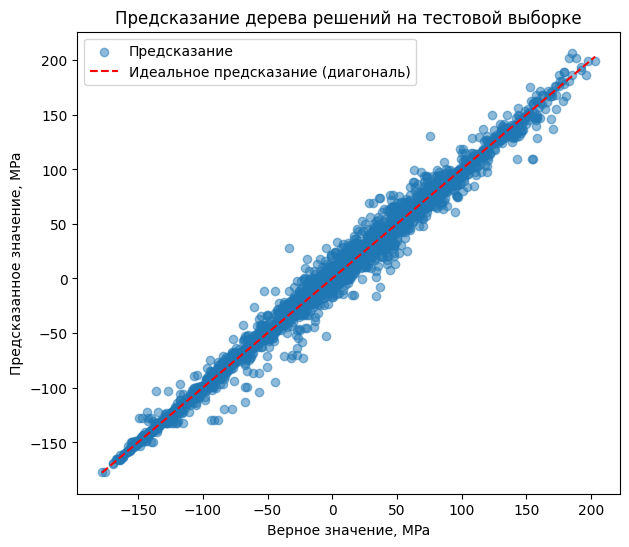

In [8]:
import matplotlib.pyplot as plt

# Plotting the results using the best model
plt.figure(figsize=(7, 6))
plt.scatter(cur_y_test, cur_y_pred_best, alpha=0.5, label="Предсказание")
plt.plot(
    [min(cur_y_test), max(cur_y_test)],
    [min(cur_y_test), max(cur_y_test)],
    color="red",
    linestyle="--",
    label="Идеальное предсказание (диагональ)",
)
plt.xlabel("Верное значение, MPa")
plt.ylabel("Предсказанное значение, MPa")
plt.title("Предсказание дерева решений на тестовой выборке")
plt.legend()
plt.savefig(f"best_decision_tree_prediction_{component_num}.png", dpi=400)
plt.show()
